Install & imports

In [1]:
!pip -q install pandas numpy scikit-learn matplotlib seaborn plotly openpyxl

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from datetime import timedelta
import plotly.express as px

pd.set_option("display.max_columns", 200)
sns.set(context="notebook", style="whitegrid")
np.random.seed(42)

Load your file

In [2]:
INPUT_FILES = ["online_retail_II.xlsx"]

def load_any(path):
    name = path.lower()
    if name.endswith(".csv"):
        return pd.read_csv(path)
    elif name.endswith((".xlsx", ".xls")):
        # openpyxl engine is required for .xlsx
        return pd.read_excel(path, engine="openpyxl")
    else:
        raise ValueError(f"Unsupported file type: {path}")

dfs = [load_any(p) for p in INPUT_FILES]
df_raw = pd.concat(dfs, ignore_index=True)
print(df_raw.shape)
df_raw.head()

(525461, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Standardize columns & clean

In [3]:
df = df_raw.copy()
df.columns = [c.strip() for c in df.columns]

colmap = {
    "Invoice": "InvoiceNo",
    "Invoice No": "InvoiceNo",
    "InvoiceNo": "InvoiceNo",
    "StockCode": "StockCode",
    "Description": "Description",
    "Quantity": "Quantity",
    "InvoiceDate": "InvoiceDate",
    "Invoice Date": "InvoiceDate",
    "UnitPrice": "UnitPrice",
    "Price": "UnitPrice",              # some versions use 'Price'
    "Unit Price": "UnitPrice",
    "CustomerID": "CustomerID",
    "Customer ID": "CustomerID",
    "Country": "Country"
}
df = df.rename(columns={k: v for k, v in colmap.items() if k in df.columns})

required = ["InvoiceNo","StockCode","Description","Quantity","InvoiceDate","UnitPrice","CustomerID","Country"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Types
df["InvoiceNo"]   = df["InvoiceNo"].astype(str).str.strip()
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["Quantity"]    = pd.to_numeric(df["Quantity"], errors="coerce")
df["UnitPrice"]   = pd.to_numeric(df["UnitPrice"], errors="coerce")
df["CustomerID"]  = pd.to_numeric(df["CustomerID"], errors="coerce")

# Remove cancellations/negatives/nulls
df = df[~df["InvoiceNo"].str.upper().str.startswith("C")]
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df = df.dropna(subset=["CustomerID","InvoiceDate"])
df["CustomerID"] = df["CustomerID"].astype(int)

# Revenue per line
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

print(df.shape)
df.head()

(407664, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


EDA

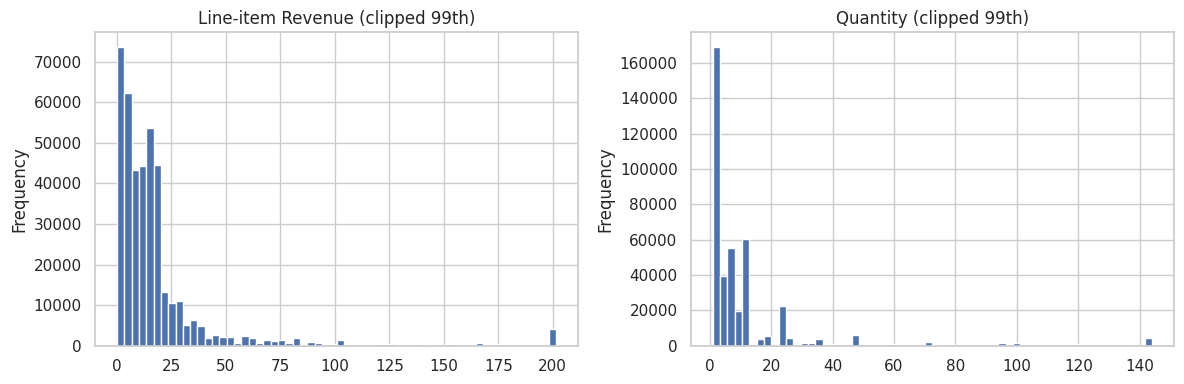

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
InvoiceNo,407664,19213,500356,270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,407664,4017,85123A,3153,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,407664,4444,WHITE HANGING HEART T-LIGHT HOLDER,3153,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,407664.0,NaN,NaN,NaN,13.585585,1.0,2.0,5.0,12.0,19152.0,96.840747
InvoiceDate,407664,NaN,NaN,NaN,2010-07-01 10:15:11.871688192,2009-12-01 07:45:00,2010-03-26 14:01:00,2010-07-09 15:47:00,2010-10-14 17:09:00,2010-12-09 20:01:00,NaN
UnitPrice,407664.0,NaN,NaN,NaN,3.294438,0.001,1.25,1.95,3.75,10953.5,34.757965
CustomerID,407664.0,NaN,NaN,NaN,15368.592598,12346.0,13997.0,15321.0,16812.0,18287.0,1679.762138
Country,407664,37,United Kingdom,370929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,407664.0,NaN,NaN,NaN,21.664909,0.001,4.95,11.9,19.5,15818.4,77.150058


In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
df["Revenue"].clip(upper=df["Revenue"].quantile(0.99)).plot(kind="hist", bins=60, ax=ax[0], title="Line-item Revenue (clipped 99th)")
df["Quantity"].clip(upper=df["Quantity"].quantile(0.99)).plot(kind="hist", bins=60, ax=ax[1], title="Quantity (clipped 99th)")
plt.tight_layout(); plt.show()

df.describe(include="all").T.head(12)

Build RFM per customer

In [5]:
snapshot_date = df["InvoiceDate"].max() + timedelta(days=1)

rfm = (
    df.groupby("CustomerID", as_index=False)
      .agg(
          Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
          Frequency=("InvoiceNo", "nunique"),
          Monetary=("Revenue", "sum")
      )
)

# Trim extreme top spenders for stable scaling (optional)
q99 = rfm["Monetary"].quantile(0.99)
rfm = rfm[rfm["Monetary"] <= q99].copy()

rfm.shape, rfm.head()

((4268, 4),
    CustomerID  Recency  Frequency  Monetary
 0       12346      165         11    372.86
 1       12347        3          2   1323.32
 2       12348       74          1    222.16
 3       12349       43          3   2671.14
 4       12351       11          1    300.93)

Scale & choose k via silhouette

In [6]:
X = rfm[["Recency","Frequency","Monetary"]].replace([np.inf,-np.inf], np.nan).dropna()

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

scores, labels_by_k = {}, {}
for k in range(3, 9):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    lab = km.fit_predict(Xs)
    scores[k] = silhouette_score(Xs, lab)
    labels_by_k[k] = (lab, km)

print("Silhouette by k:", scores)
best_k = max(scores, key=scores.get)
best_k

Silhouette by k: {3: np.float64(0.5289350186668653), 4: np.float64(0.5114309034852221), 5: np.float64(0.48450788490113644), 6: np.float64(0.43704571300750805), 7: np.float64(0.42723151032001344), 8: np.float64(0.42129708758977685)}


3

Final KMeans & attach segment IDs

In [7]:
labels, km_model = labels_by_k[best_k]
rfm = rfm.loc[X.index].copy()
rfm["segment_id"] = labels
rfm.head()

,CustomerID,Recency,Frequency,Monetary,segment_id
0,12346,165,11,372.86,0
1,12347,3,2,1323.32,0
2,12348,74,1,222.16,0
3,12349,43,3,2671.14,0
4,12351,11,1,300.93,0


Segment summary + heuristic names

In [8]:
summary = rfm.groupby("segment_id", as_index=False).agg(
    customers=("CustomerID","count"),
    Recency_mean=("Recency","mean"),
    Frequency_mean=("Frequency","mean"),
    Monetary_mean=("Monetary","mean"),
)

# Ranks (lower recency is better/fresher)
r_rec  = summary["Recency_mean"].rank(ascending=True,  method="dense")
r_freq = summary["Frequency_mean"].rank(ascending=False, method="dense")
r_mon  = summary["Monetary_mean"].rank(ascending=False, method="dense")

def suggest_name(row):
    sid = row["segment_id"]
    rr, rf, rm = int(r_rec[sid]), int(r_freq[sid]), int(r_mon[sid])
    if rm == 1 and rf <= 2 and rr <= 2:   return "High-Value Loyalists"
    if rf == 1 and rr <= 2:               return "Frequent Actives"
    if rm >= best_k-1 and rr >= best_k-1: return "At-Risk Dormants"
    if rm <= 2 and rr <= 3:               return "Promising Growers"
    return "Value-Conscious Occasionals"

names = {int(row.segment_id): suggest_name(row) for _, row in summary.iterrows()}
rfm["segment_name"] = rfm["segment_id"].map(names)
summary["segment_name"] = summary["segment_id"].map(names)
summary = summary.sort_values("Monetary_mean", ascending=False).reset_index(drop=True)
summary

,segment_id,customers,Recency_mean,Frequency_mean,Monetary_mean,segment_name
0,2,337,25.477745,15.406528,7359.375380,High-Value Loyalists
1,0,2904,45.819215,3.481405,1147.021286,At-Risk Dormants
2,1,1027,243.919182,1.577410,471.617755,At-Risk Dormants


2D visualization (PCA)

In [9]:
Z2 = PCA(n_components=2, random_state=42).fit_transform(Xs)
viz = pd.DataFrame({"pc1": Z2[:,0], "pc2": Z2[:,1], "segment": rfm["segment_name"].values})

px.scatter(
    viz.sample(min(5000, len(viz))),
    x="pc1", y="pc2", color="segment",
    title=f"Customer Segments (k={best_k})"
).show()

Export CSVs next to your notebook

In [10]:
rfm[["CustomerID","Recency","Frequency","Monetary","segment_id","segment_name"]].to_csv("segment_assignments.csv", index=False)
summary.to_csv("segment_summary.csv", index=False)
print("Wrote: segment_assignments.csv, segment_summary.csv")

Wrote: segment_assignments.csv, segment_summary.csv


Executive stats

In [11]:
largest = rfm["segment_name"].value_counts().idxmax()
avg_monetary = rfm["Monetary"].mean()

exec_stats = {
    "customers_clustered": int(rfm["CustomerID"].nunique()),
    "k": int(best_k),
    "largest_segment": largest,
    "avg_monetary": float(avg_monetary)
}
exec_stats

{'customers_clustered': 4268,
 'k': 3,
 'largest_segment': 'At-Risk Dormants',
 'avg_monetary': 1475.0259491565137}

In [12]:
blurb = (
    f"Built an end-to-end RFM-based segmentation on {exec_stats['customers_clustered']:,} customers; "
    f"selected k={exec_stats['k']} via silhouette and clustered with KMeans. "
    f"Identified personas (e.g., '{exec_stats['largest_segment']}') to drive targeted lifecycle marketing "
    f"and retention campaigns."
)
print(blurb)

Built an end-to-end RFM-based segmentation on 4,268 customers; selected k=3 via silhouette and clustered with KMeans. Identified personas (e.g., 'At-Risk Dormants') to drive targeted lifecycle marketing and retention campaigns.
